In [2]:
import pathlib

wiki, version, langcode = 'simplewiki', '20211120', 'en'
# wiki, version, langcode = 'tawiki', '20220301', 'ta'
# wiki, version, langcode = 'fawiki', '20220301', 'fa'
# wiki, version, langcode = 'trwiki', '20220301', 'tr'
# wiki, version, langcode = 'nlwiki', '20220301', 'nl'
# wiki, version, langcode = 'arwiki', '20220301', 'ar'
# wiki, version, langcode = 'srwiki', '20220301', 'sr'
# wiki, version, langcode = 'eswiki', '20220301', 'es'
usefeats = False

fpreds = sorted(pathlib.Path(f'wiki/{wiki}-{version}/experiments/').glob('*.tsv'))
fgold = pathlib.Path(f'evaluation/Mewsli-9/{langcode}.tsv')

from minimel import evaluate
df = evaluate(fgold, *fpreds)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:30<00:00,  1.35it/s]


In [3]:
import pandas as pd

# Load ablations
abl = pd.Series(df.index).str.extract(
    'pred-mewsli.'
    '(?P<kind>\w+)'
    '-?(?P<q>q0.25|q0.5|q1)?'
    '(?P<f>.feat-clean-q1\.p[.0-9]+?)?'
    '(?P<b>.\d+b)?'
    '(?P<c>\..*?)?$'
)
abl['c'] = abl['c'].fillna('')
abl['c'] = abl.apply(
    lambda s: (s['c']!='') if s['kind'] not in ['base', 'upper'] else s['c'], axis=1)
abl['b'] = abl['b'].str[1:-1].astype('float').astype('Int32')
abl['f'] = abl['f'].fillna('')
abl['kind'] = abl['kind'].replace('stem', 'clean-stem')


f1 = df.set_index(pd.MultiIndex.from_frame(abl))[('micro','fscore')].rename('f1')

f = (f1.index.get_level_values('f')!='') if usefeats else (f1.index.get_level_values('f')=='')
d = (f1.index.get_level_values('kind')=='base') | (f1.index.get_level_values('kind')=='upper')
f1 = f1[d | f]
f1 = f1.droplevel('f')
f1

kind        q      b    c             
base        NaN    NaN  .clean-q1         0.418123
                        .clean-stem-q1    0.428182
                                          0.397836
clean       q0.25  16   True              0.416432
                        False             0.406203
                   20   True              0.418779
                        False             0.408550
                   24   True              0.419513
                        False             0.409285
            q0.5   16   True              0.414452
                        False             0.408904
                   20   True              0.417782
                        False             0.412235
                   24   True              0.419317
                        False             0.413770
            q1     16   True              0.409691
                        False             0.409691
                   20   True              0.416287
                        False             0

/tmp/ipykernel_17794/3751490675.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


<Figure size 864x576 with 0 Axes>

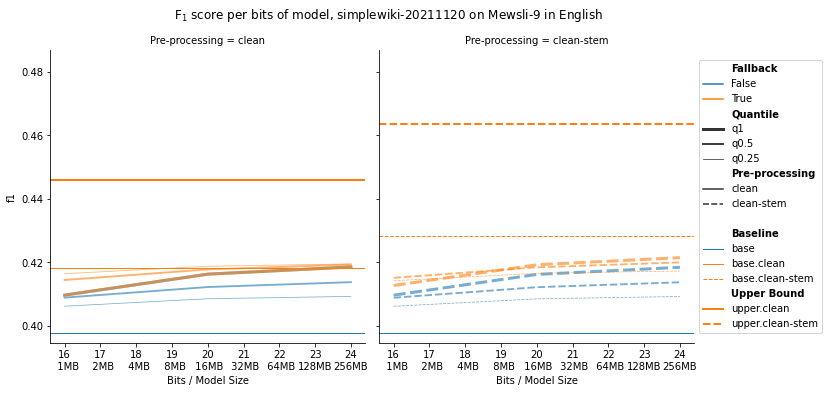

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# PLOTTING

data = f1[f1.index.drop(['base', 'upper'])].reset_index().rename(columns={
    'c': 'Fallback',
    'q': 'Quantile',
    'b': 'Bits',
    'kind': 'Pre-processing',
}).sort_values(['Pre-processing','Quantile'], ascending=[1,0])

fig = plt.figure(figsize=(12,8))
g = sns.relplot(
    kind='line', data=data,
    x='Bits', y='f1', hue='Fallback', col='Pre-processing', style='Pre-processing', size='Quantile',
    alpha=.6)

handles, labels = g._legend.get_lines(), [t.get_text() for t in g._legend.get_texts()]
handles.append( handles[0] ), labels.append('')

handles.append( handles[0] ), labels.append('Baseline')
for (_,_,c), basef1 in f1.loc['base'].sort_index().iteritems():
    ls = '--' if ('stem' in c) else '-'
    color = 'C1' if c else 'C0'
    label = f'base{c[:-3]}'
    for ax in g.axes.flatten():
        if (not c) or (('stem' in c) == ('stem' in ax.get_title())):
            h = ax.axhline(basef1, ls=ls, linewidth=1, color=color, label=label)
    handles.append( h )
    labels.append(label)

handles.append( handles[0] ), labels.append('Upper Bound')
for (_,_,c), basef1 in f1.loc['upper'].sort_index().iteritems():
    ls = '--' if ('stem' in c) else '-'
    color = 'C1' if c else 'C0'
    label = f'upper{c[:-3]}'
    for ax in g.axes.flatten():
        if (not c) or (('stem' in c) == ('stem' in ax.get_title())):
            h = ax.axhline(basef1, ls=ls, linewidth=2, color=color, label=label)
    handles.append( h )
    labels.append(label)

g._legend.remove()
legend = plt.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
for h, text in zip(handles, legend.get_texts()):
    if not h.get_visible():
        text.set_fontweight('bold')
y0,y1 = ax.get_ylim()
ax.set_ylim([y0, y1+.02])

def sizeof_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"
for ax in g.axes.flatten():
    l = [f'{int(x)}\n{sizeof_fmt(2**x*16)}' for x in ax.get_xticks()]
    ax.set_xticklabels(l)
    ax.set_xlabel('Bits / Model Size')

from minimel import code_name
code_name['fa'] = 'Persian'
code_name['ja'] = 'Japanese'
langname = code_name.get(langcode).title()
g.figure.suptitle(f'F$_1$ score per bits of model, {wiki}-{version} on Mewsli-9 in {langname}', y=1.05)

plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.savefig(f'paper/{wiki}-{version}.pgf', bbox_inches='tight')
None

# Which mentions are unobserved in the training data?

In [5]:
import pandas as pd
import json, glob, dawg
from minimel.normalize import normalize

counts = json.load(open(f'wiki/{wiki}-{version}/experiments/clean-q1.json'))
disambig = set(pd.read_csv('data/wikidata-20211122-disambig.txt', header=None)[0])
index = glob.glob(f'wiki/{wiki}-*/index_{wiki}-*.dawg')[0]
wm = dawg.IntDAWG().load(index)
    
def rank(wm, counts, surface, i, stem=None):
    """Return count and rank (rank = -1 means only in page title index)"""
    for norm in normalize(surface, language=stem):
        norm = norm.lower()
        ent_count = counts.get(norm, {})
        if len(ent_count) == 1 and ent_count.get('%s'%i):
            return ent_count['%s'%i], -1
        if ent_count.get('%s'%i):
            order = sorted(ent_count, key=lambda x: -ent_count[x])
            return ent_count['%s'%i], order.index('%s'%i)
    if wm.get(surface[0].upper() + surface[1:].replace(' ','_')) == i:
        return 1, -1
    return 0, None

ranks = pd.DataFrame([
    (surface, ref, *rank(wm, counts, surface, ref))
    for _, links, text in (l.split('\t') for l in fgold.open())
    for surface, ref in json.loads(links).items()
    if ref not in disambig
], columns=['surface', 'ref', 'count', 'rank'])

In [6]:
test_counts = ranks.fillna('na').value_counts().rename('test_count').reset_index()
test_counts.query('(count == 0) & (rank == "na")').head(20)

,surface,ref,count,rank,test_count
22,H5N1,160122,0,na,59
40,World Cup,1127675,0,na,45
64,Wikimedia,3568028,0,na,35
77,Church of Scientology,1820380,0,na,32
83,Alexander Downer,1239291,0,na,31
93,2007 Rugby World Cup,124753,0,na,30
99,caught,705379,0,na,29
102,P D Collingwood,983731,0,na,29
104,British Columbia,1974,0,na,29
105,K P Pietersen,1398682,0,na,29


# Which features are used to classify the hardest entities?

In [7]:
hard_ents = test_counts.query('rank==1')['surface']
test_counts.set_index('surface').loc[list(hard_ents)]

,ref,count,rank,test_count
surface,,,,
China,148,284,1.0,88
China,130582,45,2.0,4
China,220853,0,na,1
Ferrari,27586,45,1.0,31
Ferrari,173355,0,na,1
...,...,...,...,...
Iwaki,274384,5,1.0,1
Israel,191406,17,1.0,1
Israel,2277185,0,na,1


In [1]:
test_counts

NameError: name 'test_counts' is not defined